# Introduction




# Prepare for analysis

## Load packages

In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))
from prelim_utils import *
from eda_univariate import *
from feature_engineering import *
from baseline import *
from name_proc import *

In [6]:
# TODO: Add all hard coded parameters like file paths or model parameters here
# PATHS
DATA_PATH = Path("../data")
TRAIN_PATH = DATA_PATH / "train.csv"
TEST_PATH = DATA_PATH / "test.csv"

# Proportion of data to use for validation
VALID_SIZE = 0.2

# Parameters for model training
n_jobs = -1
random_state = 42 
criterion = "gini"
n_estimators = 100
verbose = False

# Color palette
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0b2447"]


## Read the data

In [7]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Preliminary data inspection

## Quick glimpse of the data
TODO: Think if you can abstract away much here.

In [8]:
display_data_overview(train_df, "Training Data")

--- Training Data Head ---


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- Training Data Descriptive Statistics ---


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
display_data_overview(test_df, "Test Data")

--- Test Data Head ---


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S



--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB

--- Test Data Descriptive Statistics ---


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Few statistics on the data

### Missing data

In [10]:
df_missing_data = analyse_missing_data(train_df, "Training Data")

--- Missing Data in Training Data ---


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,0,177,0,0,0,0,687,2
Percent,0.0,0.0,0.0,0.0,0.0,19.86532,0.0,0.0,0.0,0.0,77.104377,0.224467
Types,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [11]:
df_missing_test = analyse_missing_data(test_df, "Test Data")

--- Missing Data in Test Data ---


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,86,0,0,0,1,327,0
Percent,0.0,0.0,0.0,0.0,20.574163,0.0,0.0,0.0,0.239234,78.229665,0.0
Types,int64,int64,object,object,float64,int64,int64,object,float64,object,object


### Most frequent data

In [12]:
frequent_train = most_frequent_data(train_df, "Training Data")

--- Most Frequent Data in Training Data ---


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,891,891,891,891,891,714,891,891,891,891,204,889
Most Frequent Item,1,0,3,"Braund, Mr. Owen Harris",male,24.0,0,0,347082,8.05,B96 B98,S
Frequency,1,549,491,1,577,30,608,678,7,43,4,644
Percent from Total,0.112,61.616,55.107,0.112,64.759,4.202,68.238,76.094,0.786,4.826,1.961,72.441


In [13]:
frequent_test = most_frequent_data(test_df, "Test Data")

--- Most Frequent Data in Test Data ---


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,418,418,418,418,332,418,418,418,417,91,418
Most Frequent Item,892,3,"Kelly, Mr. James",male,21.0,0,0,PC 17608,7.75,B57 B59 B63 B66,S
Frequency,1,218,1,266,17,283,324,5,21,3,270
Percent from Total,0.239,52.153,0.239,63.636,5.12,67.703,77.512,1.196,5.036,3.297,64.593


### Unique values

In [14]:
unique_train = analyse_unique_values(train_df, "Training Data")

--- Unique Values in Training Data ---


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,891,891,891,891,891,714,891,891,891,891,204,889
Uniques,891,2,3,891,2,88,7,7,681,248,147,3


In [15]:
unique_test = analyse_unique_values(test_df, "Test Data")

--- Unique Values in Test Data ---


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,418,418,418,418,332,418,418,418,417,91,418
Uniques,418,3,418,2,79,7,8,363,169,76,3


# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [16]:
all_df = combine_train_test(train_df, test_df)

In [17]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


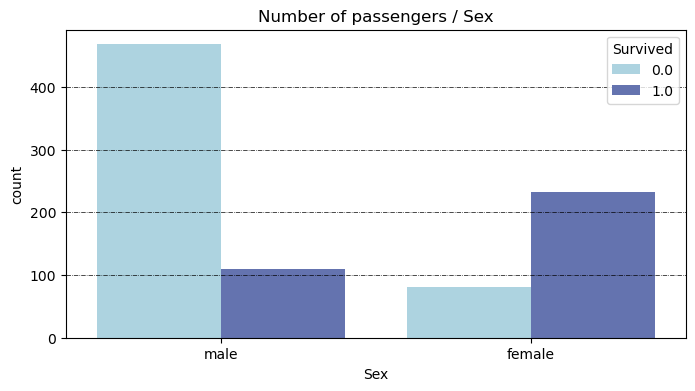

In [18]:
plot_count_pairs(all_df, ["Sex"], hue="Survived", palette=color_list)

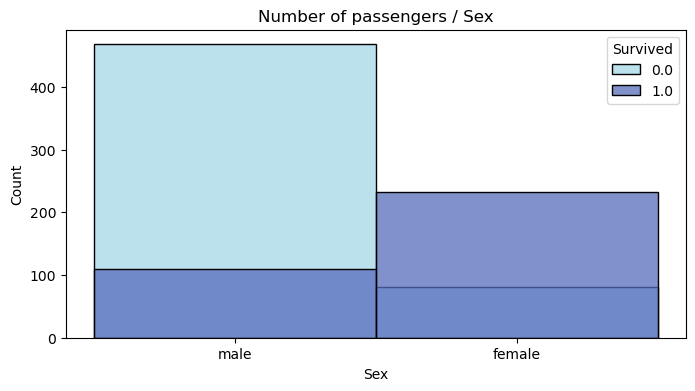

In [19]:
# Call the function
plot_distribution(all_df, "Sex", hue="Survived", palette=color_list)

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


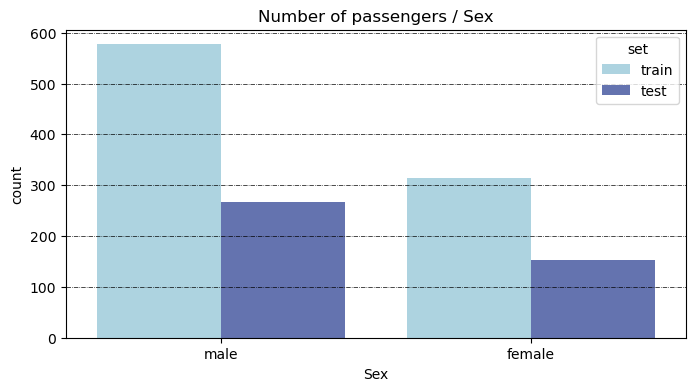

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


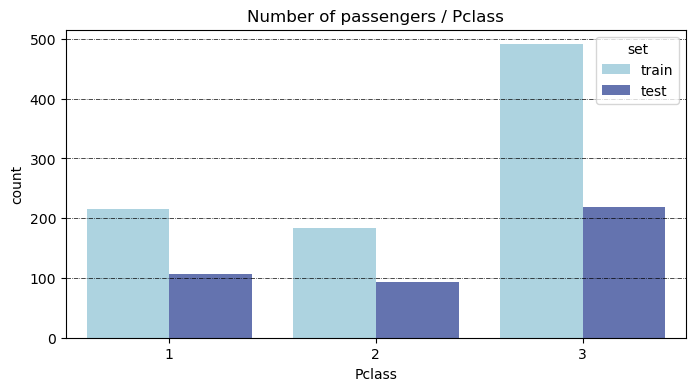

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


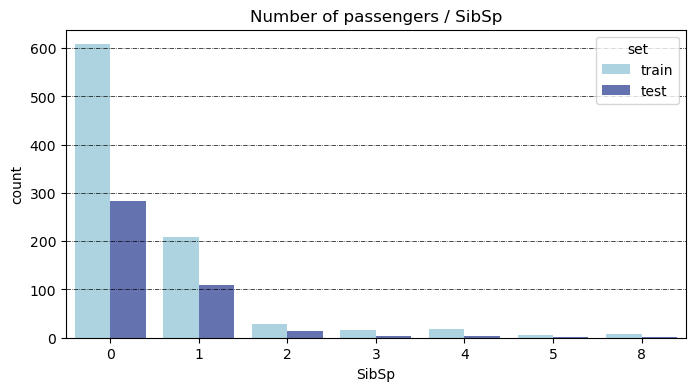

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


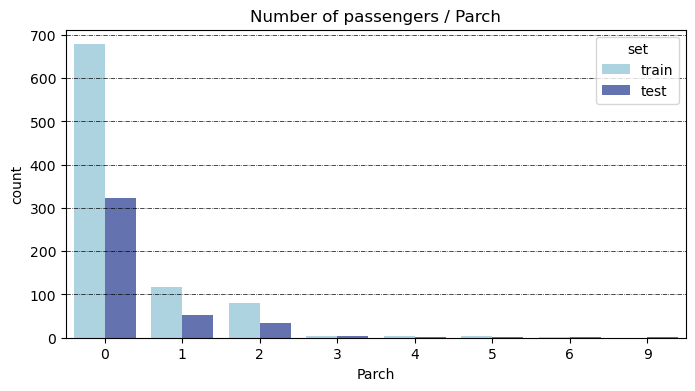

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


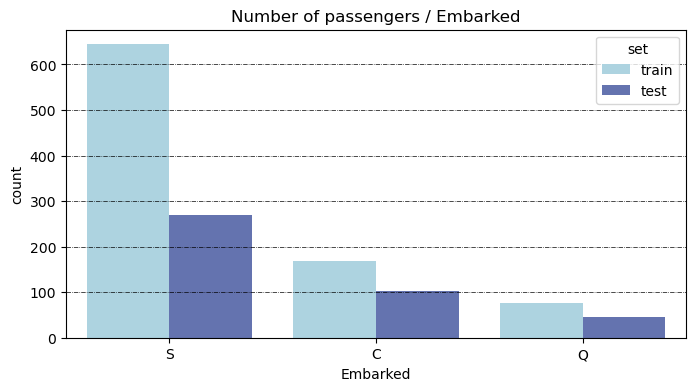

In [20]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked
plot_count_pairs(all_df, ["Sex", "Pclass", "SibSp", "Parch", "Embarked"], hue="set", palette=color_list)

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


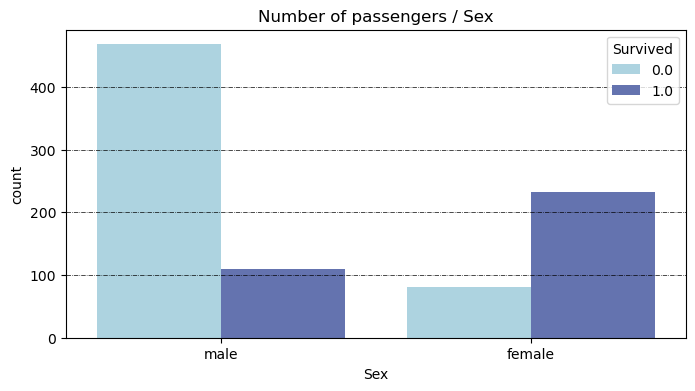

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


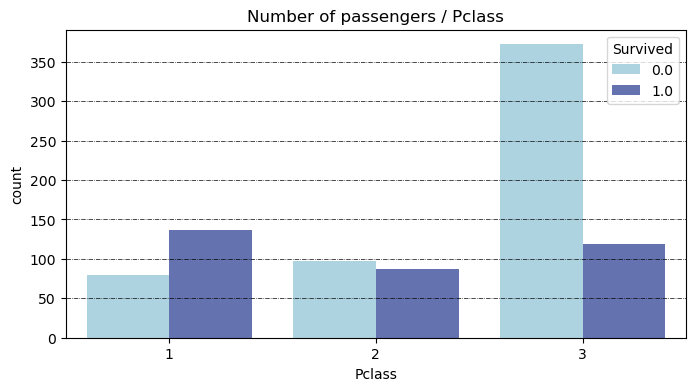

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


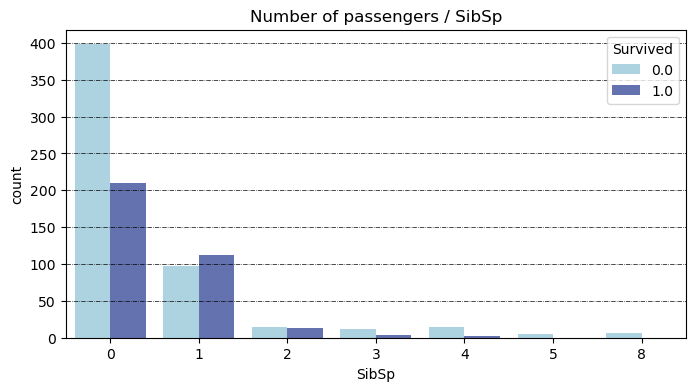

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


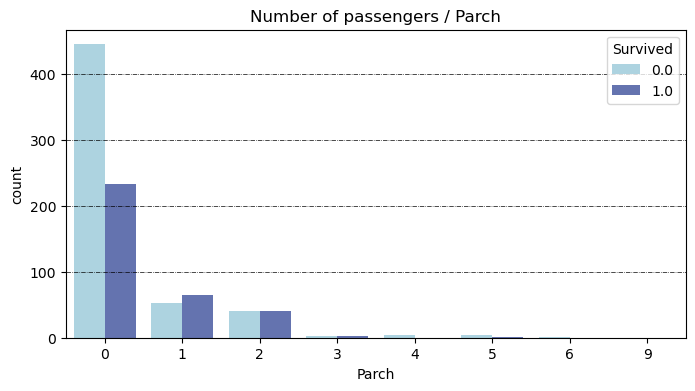

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


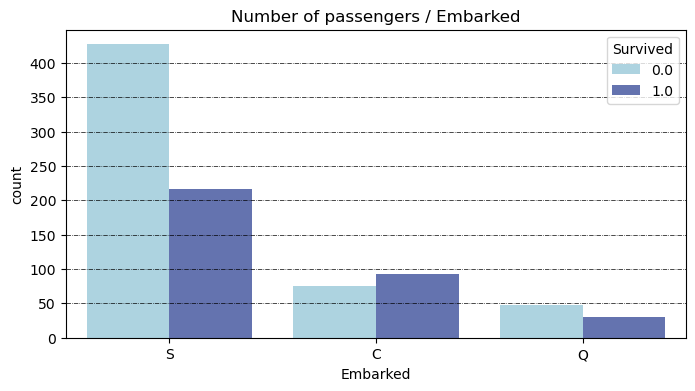

In [21]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked and use "Survived" as hue.
plot_count_pairs(all_df, ["Sex", "Pclass", "SibSp", "Parch", "Embarked"], hue="Survived", palette=color_list)

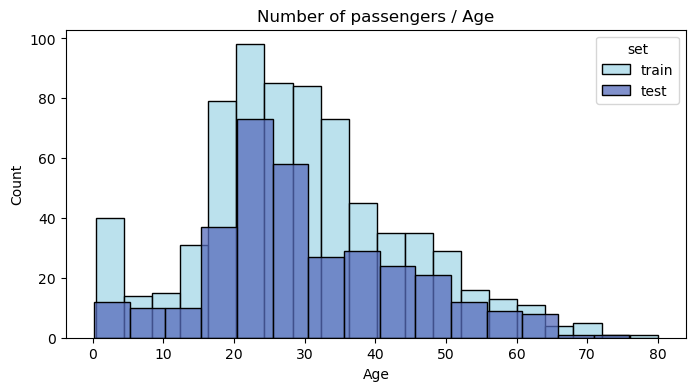

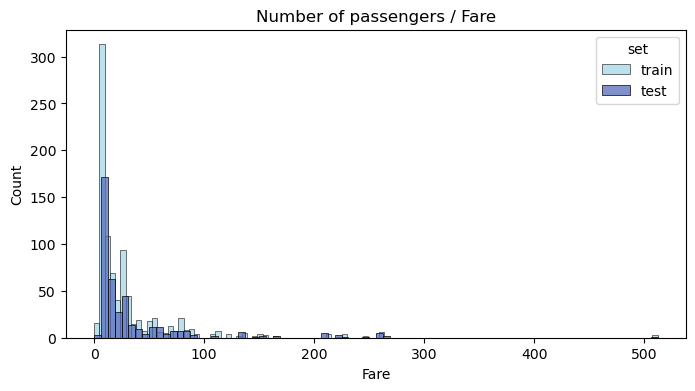

In [22]:
# Plot distribution pairs for Age and Fare
plot_distribution(all_df, "Age", hue="set", palette=color_list)
plot_distribution(all_df, "Fare", hue="set", palette=color_list)

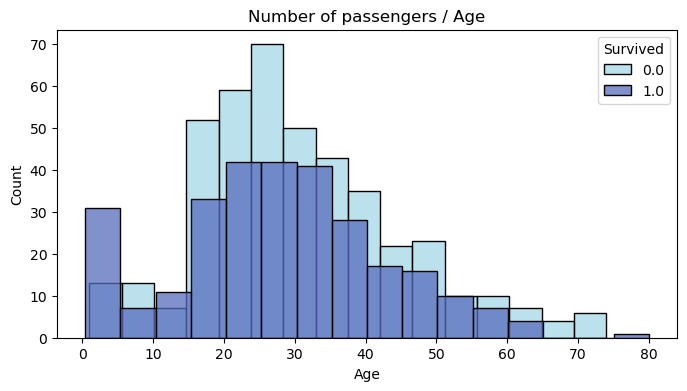

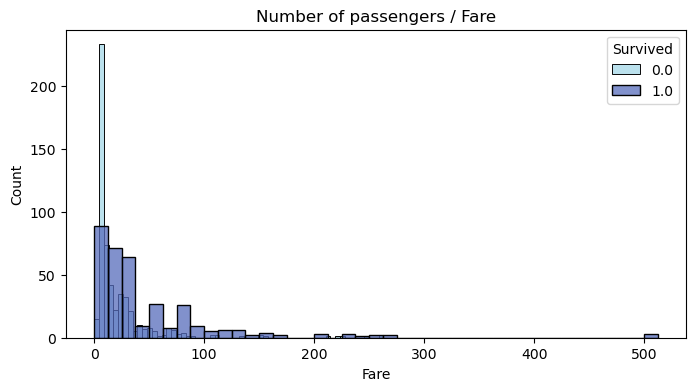

In [23]:
# Plot distribution pairs for Age and Fare using "Survived" as hue
plot_distribution(all_df, "Age", hue="Survived", palette=color_list)
plot_distribution(all_df, "Fare", hue="Survived", palette=color_list)

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [24]:
# Calculate family size for all_df
all_df["Family Size"] = calculate_family_size(all_df)

In [25]:
train_df["Family Size"] = calculate_family_size(train_df)

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


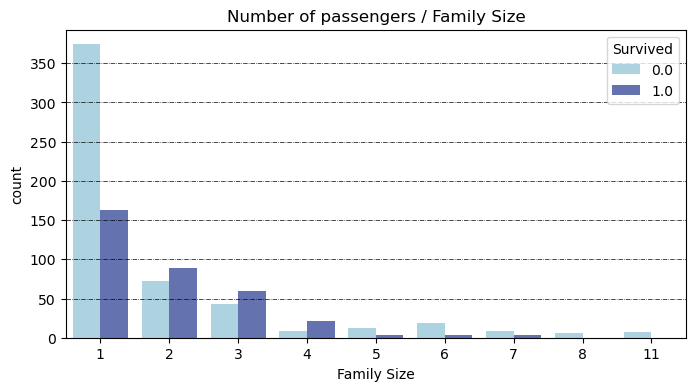

In [26]:
# Plot count pairs using all_df for the column "Family Size" and use "Survived" as hue.
plot_count_pairs(all_df, ["Family Size"], hue="Survived", palette=color_list)

## Age interval

In [27]:
all_df = create_age_intervals(all_df)

In [28]:
train_df = create_age_intervals(train_df)

In [29]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set,Family Size,Age Interval
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,2,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,2,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,1,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,2,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,1,2.0


/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


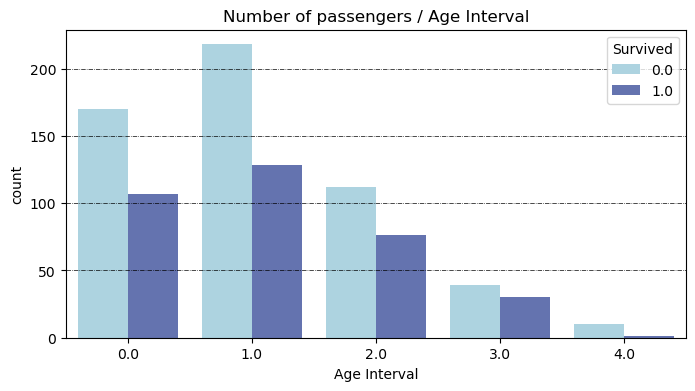

In [42]:
# Plot count pairs using all_df for the column "Age Interval" and use "Survived" as hue.
plot_count_pairs(all_df, ["Age Interval"], hue="Survived", palette=color_list)

## Fare interval

In [43]:
all_df = create_fare_intervals(all_df)

In [44]:
train_df = create_fare_intervals(train_df)

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


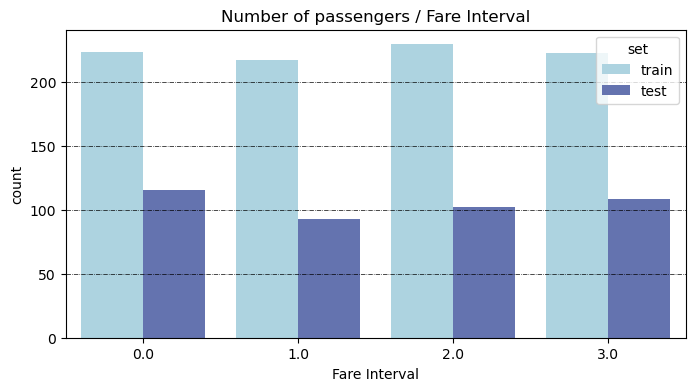

In [45]:
# Plot count pairs using all_df for the column "Fare Interval"
plot_count_pairs(all_df, ["Fare Interval"], hue="set", palette=color_list)

Let's create a composed feature: Pclass + Sex.

In [34]:
train_df = create_composed_feature(train_df, "Sex", "Pclass")

In [35]:
all_df = create_composed_feature(all_df, "Sex", "Pclass")

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


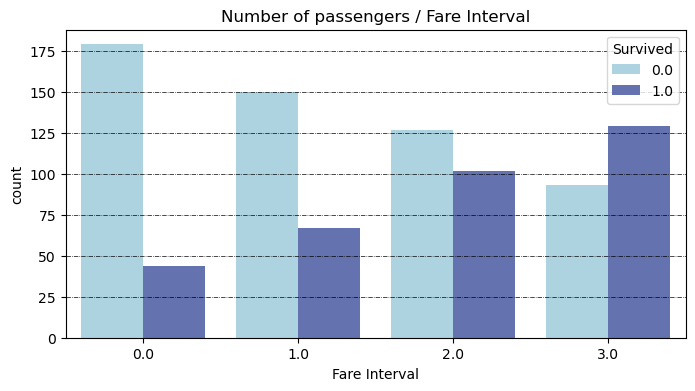

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


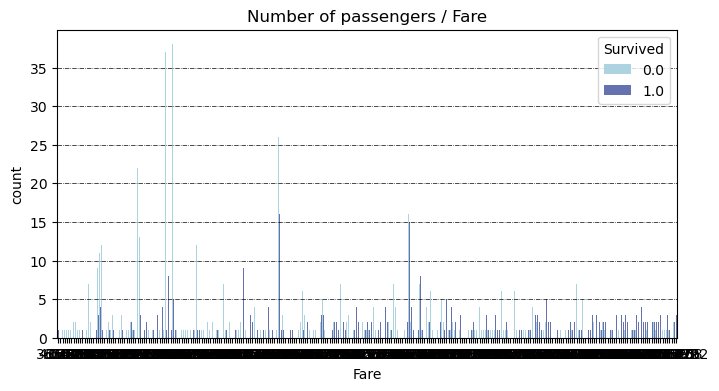

In [36]:
# Plot count pairs using all_df for the column "Fare Interval" and "Fare (grouped by survival)" with "Survived" as hue
plot_count_pairs(all_df, ["Fare Interval"], hue="Survived", palette=color_list)
plot_count_pairs(all_df, ["Fare"], hue="Survived", palette=color_list)

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [46]:
all_df = add_name_components(all_df)

In [47]:
train_df = add_name_components(train_df)

## Multivariate analysis


Let's look now to the interaction of multiple features.

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


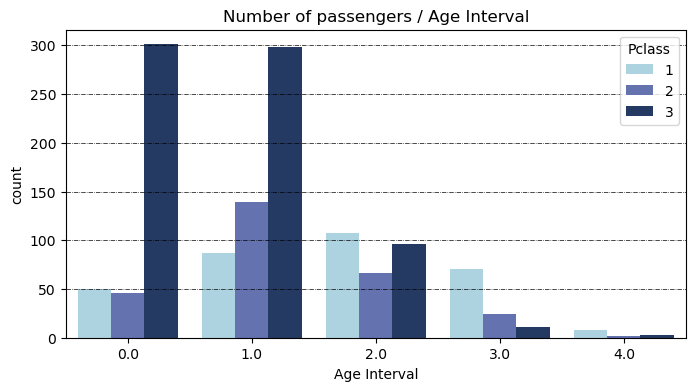

In [48]:
# TODO: Plot count pairs of "Age Interval" grouped by "Pclass"
plot_count_pairs(all_df, ["Age Interval"], hue="Pclass", palette=color_list)

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/eda_univariate.py:46: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=column, data=dataframe.reset_index(drop=True), hue=hue, palette=palette)


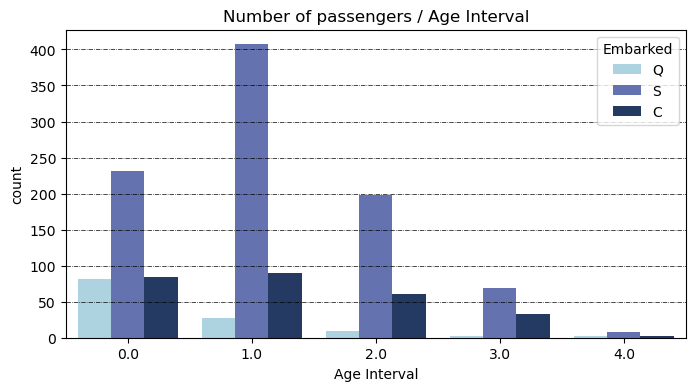

In [49]:
# TODO: Plot count pairs of "Age Interval" grouped by "Embarked"
plot_count_pairs(all_df, ["Age Interval"], hue="Embarked", palette=color_list)

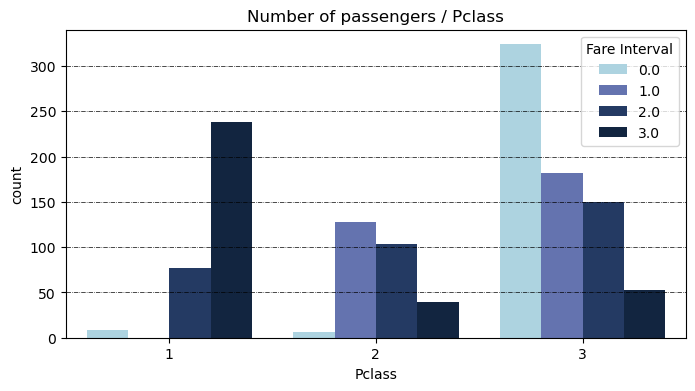

In [50]:
# TODO: Plot count pairs of "Pclass" grouped by "Fare Interval"
plot_count_pairs(all_df, ["Pclass"], hue="Fare Interval", palette=color_list)

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [51]:
all_df, train_df = categorize_family_type([all_df, train_df])

/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/feature_engineering.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"
/Users/congminhnguyen/MPhil Econs and Data Science/first_repo/titanic_problem_set/src/feature_engineering.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset["Family Size"] == 1, "Family Type"] = "Single"


In [52]:
for dataset in [all_df, train_df]:
    dataset["Titles"] = dataset["Title"]

In [53]:
all_df, train_df = unify_titles([all_df, train_df])

In [54]:
calculate_mean_survival(train_df, ["Titles", "Sex"])

,Titles,Sex,Survived
0,Master.,male,0.575000
1,Miss.,female,0.702703
2,Mr.,male,0.156673
3,Mrs.,female,0.793651
4,Rare,female,1.000000
5,Rare,male,0.250000


# Baseline model

## Feature engineering: Map categorical value to numerical values

In [55]:
train_df, test_df = map_sex_to_int([train_df, test_df])

Create train-validation split.

In [56]:
VALID_SIZE = 0.2
train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=42, shuffle=True)

Define predictor features and target feature.

In [57]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

Initialize the classifiction algorithm.

Fit the classifier with the training data.

Predict the train data (to check the training classification error).

Predict the validation data.

# Evaluation

## Classification report for training data.

Classification report for validation data.

In [61]:
# The prediction is also saved in the `preds` variable as a dictionary of two keys based on the train and validation data.
preds = base_pred(train, valid, predictors, target) 


Training Classification Report:
               precision    recall  f1-score   support

Not Survived       0.75      0.99      0.86       444
    Survived       0.96      0.47      0.63       268

    accuracy                           0.79       712
   macro avg       0.86      0.73      0.74       712
weighted avg       0.83      0.79      0.77       712

Validation Classification Report:
               precision    recall  f1-score   support

Not Survived       0.73      0.96      0.83       105
    Survived       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179



In [62]:
preds['train_predictions']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,

In [63]:
preds['valid_predictions']

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0])